In [1]:
"""
Tutorial: Predicting Customer Churn with a Keras-based Deep Neural Network

Overview:
This tutorial demonstrates how to predict customer churn using a deep neural network (DNN) with Keras.
We work with the Telco Customer Churn dataset and walk through data preprocessing, model building,
training with early stopping, and evaluation. Creative visualizations (interactive ROC curve, radar chart,
swarm plot, and smoothed learning curve) help us interpret model performance and feature importance.

"""

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set a fresh plotting style
plt.style.use("ggplot")
sns.set_theme(style="whitegrid", palette="coolwarm")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
# 1. Data Loading and Exploration
# Load the Telco Customer Churn dataset (ensure 'telco_churn.csv' is available in your directory)
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Dataset shape:", df.shape)
print("\nDataset preview:")
df.head()

Dataset shape: (7043, 21)

Dataset preview:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print("\nData info:")
df.info()


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-nul

In [6]:
print("\nTarget distribution (Churn):")
df['Churn'].value_counts()


Target distribution (Churn):


,count
Churn,
No,5174
Yes,1869


In [7]:
# 2. Data Preprocessing
# Convert 'TotalCharges' to numeric (if needed) and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

<ipython-input-7-468fc5b0e5d3>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [8]:
# Define target variable: Convert 'Churn' to binary (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identify categorical columns (excluding ID)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID') if 'customerID' in categorical_cols else None

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df.drop(columns=['customerID']), columns=categorical_cols, drop_first=True)

In [9]:
print("\nColumns after encoding:")
print(df_encoded.columns)


Columns after encoding:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [10]:
# Separate features and target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']


In [11]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [12]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5634, 30)
Test set shape: (1409, 30)


In [13]:
# 4. Model Building with Keras (Deep Neural Network)
def build_dnn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = X_train.shape[1]
model = build_dnn_model(input_dim)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 14,785 (57.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# 5. Model Training with Early Stopping
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6459 - loss: 0.7383 - val_accuracy: 0.7915 - val_loss: 0.5001
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7441 - loss: 0.5512 - val_accuracy: 0.7933 - val_loss: 0.4623
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7708 - loss: 0.5050 - val_accuracy: 0.7915 - val_loss: 0.4551
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7811 - loss: 0.4667 - val_accuracy: 0.7879 - val_loss: 0.4502
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7801 - loss: 0.4828 - val_accuracy: 0.7879 - val_loss: 0.4466
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7931 - loss: 0.4410 - val_accuracy: 0.7915 - val_loss: 0.4474
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7824 - loss: 0.4506 - val_accuracy: 0.7862 - val_loss: 0.4459
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7860 - loss: 0.4472 - val_accuracy: 0.7915 -

In [16]:
# 6. Model Evaluation
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.50      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [17]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[922 113]
 [187 187]]


In [18]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.3f}")

ROC AUC Score: 0.835


In [19]:
## 7.1 Interactive Plotly ROC Curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines+markers',
                         line=dict(color='darkblue', dash='dash'),
                         name=f'ROC Curve (AUC = {roc_auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                         line=dict(color='gray', dash='dot'),
                         name='Baseline'))
fig.update_layout(
    title="Interactive ROC Curve for Credit Churn Prediction",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    hovermode="closest"
)
fig.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (32,) and (31,)

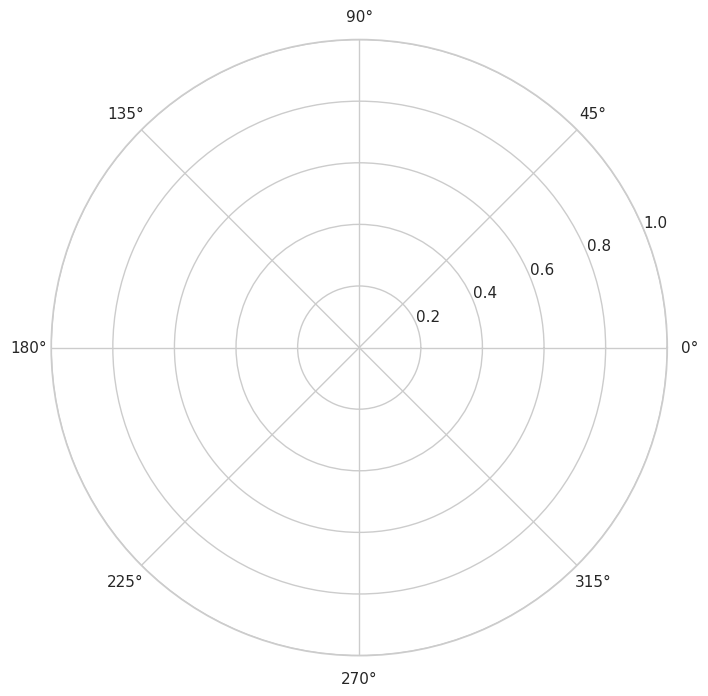

In [23]:
# 7.2 Radar Chart for Permutation Feature Importance (Fixed)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance

# Wrapper class to make CatBoost compatible with permutation_importance
class CatBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        # No need to fit again since model is already trained
        return self

    def predict(self, X):
        # Direct prediction and rounding to binary output
        return (self.model.predict(X) > 0.5).astype(int)

# Wrap the trained CatBoost model
wrapper = CatBoostWrapper(model)

# Compute permutation importance using the wrapped model
perm_importance = permutation_importance(
    wrapper,
    X_test,
    y_test,
    scoring='accuracy',
    n_repeats=10,
    random_state=42
)

importance_values = perm_importance.importances_mean
features = X_test.columns.tolist()

# Normalize for radar chart
norm_importance = importance_values / np.max(importance_values)

# Prepare data for radar chart
features_radar = features + [features[0]]
values_radar = norm_importance.tolist() + [norm_importance[0]]

angles = np.linspace(0, 2 * np.pi, len(features_radar), endpoint=False).tolist()
angles += angles[:1]

# Create the radar chart
fig_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values_radar, 'o-', linewidth=2, color='green')
ax.fill(angles, values_radar, alpha=0.25, color='green')
ax.set_thetagrids(np.degrees(angles[:-1]), features_radar)
ax.set_title("Radar Chart of Permutation Feature Importance", y=1.1, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-24-7c3223cf5d77>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




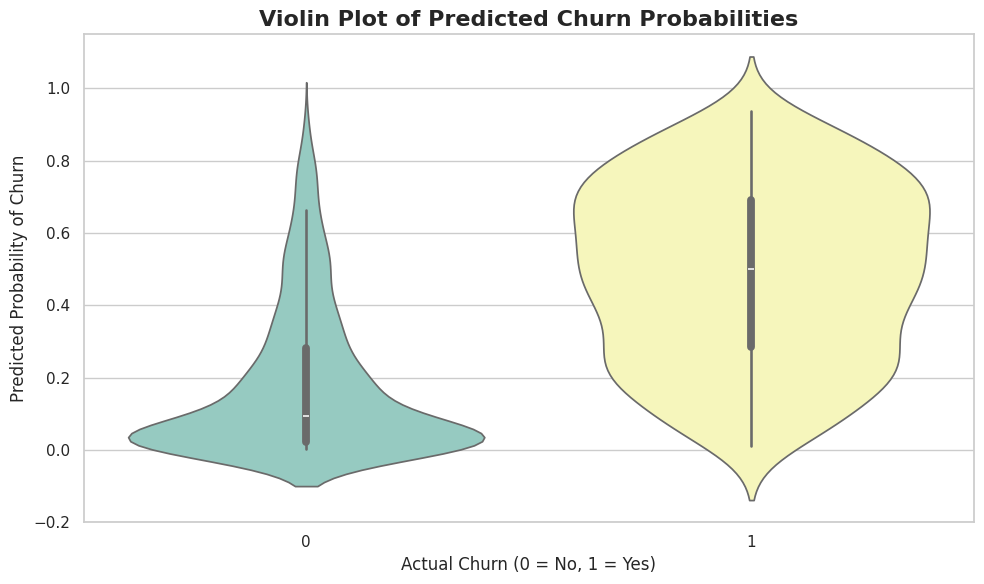

In [24]:
## 7.3 Violin Plot of Predicted Probabilities
df_prob = pd.DataFrame({'Actual': y_test, 'Predicted_Prob': y_pred_prob})
plt.figure(figsize=(10,6))
sns.violinplot(x='Actual', y='Predicted_Prob', data=df_prob, palette="Set3")
plt.title("Violin Plot of Predicted Churn Probabilities", fontsize=16, fontweight='bold')
plt.xlabel("Actual Churn (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Predicted Probability of Churn", fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
## 7.4 3D Scatter Plot: Actual vs Predicted vs Residuals
residuals = y_test - y_pred_prob
df_3d = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_prob,
    "Residual": residuals
})
fig3d = px.scatter_3d(df_3d, x="Actual", y="Predicted", z="Residual",
                      color="Residual", color_continuous_scale='Plasma',
                      title="3D Scatter: Actual, Predicted, and Residuals")
fig3d.update_layout(scene=dict(
    xaxis_title="Actual Churn",
    yaxis_title="Predicted Probability",
    zaxis_title="Residual"
))
fig3d.show()

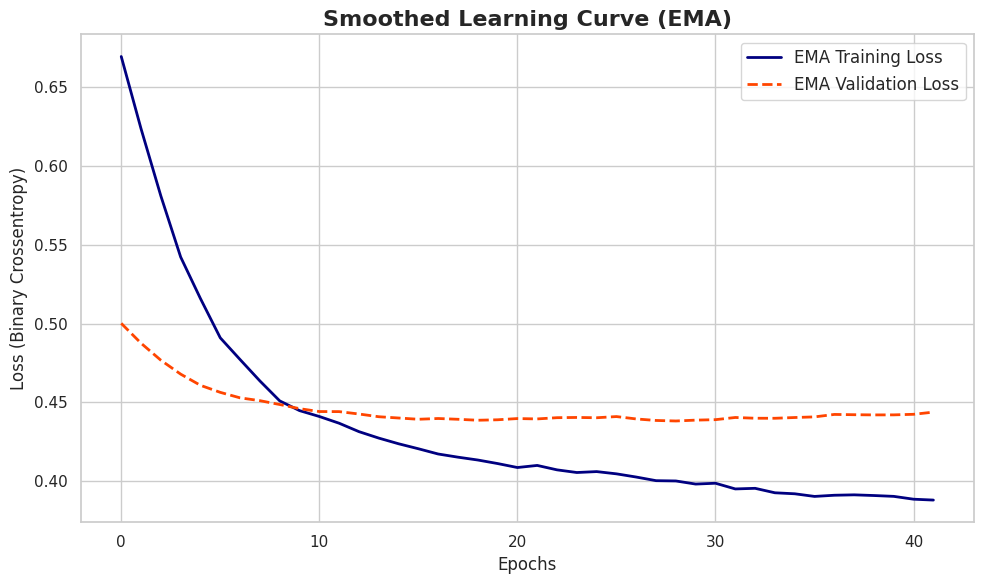

In [26]:
## 7.5 Smoothed Learning Curve (EMA)
loss_df = pd.DataFrame(history.history)
loss_df['EMA_train'] = loss_df['loss'].ewm(span=5, adjust=False).mean()
loss_df['EMA_val'] = loss_df['val_loss'].ewm(span=5, adjust=False).mean()
plt.figure(figsize=(10,6))
plt.plot(loss_df['EMA_train'], label='EMA Training Loss', color='navy', linewidth=2)
plt.plot(loss_df['EMA_val'], label='EMA Validation Loss', color='orangered', linewidth=2, linestyle='--')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (Binary Crossentropy)", fontsize=12)
plt.title("Smoothed Learning Curve (EMA)", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


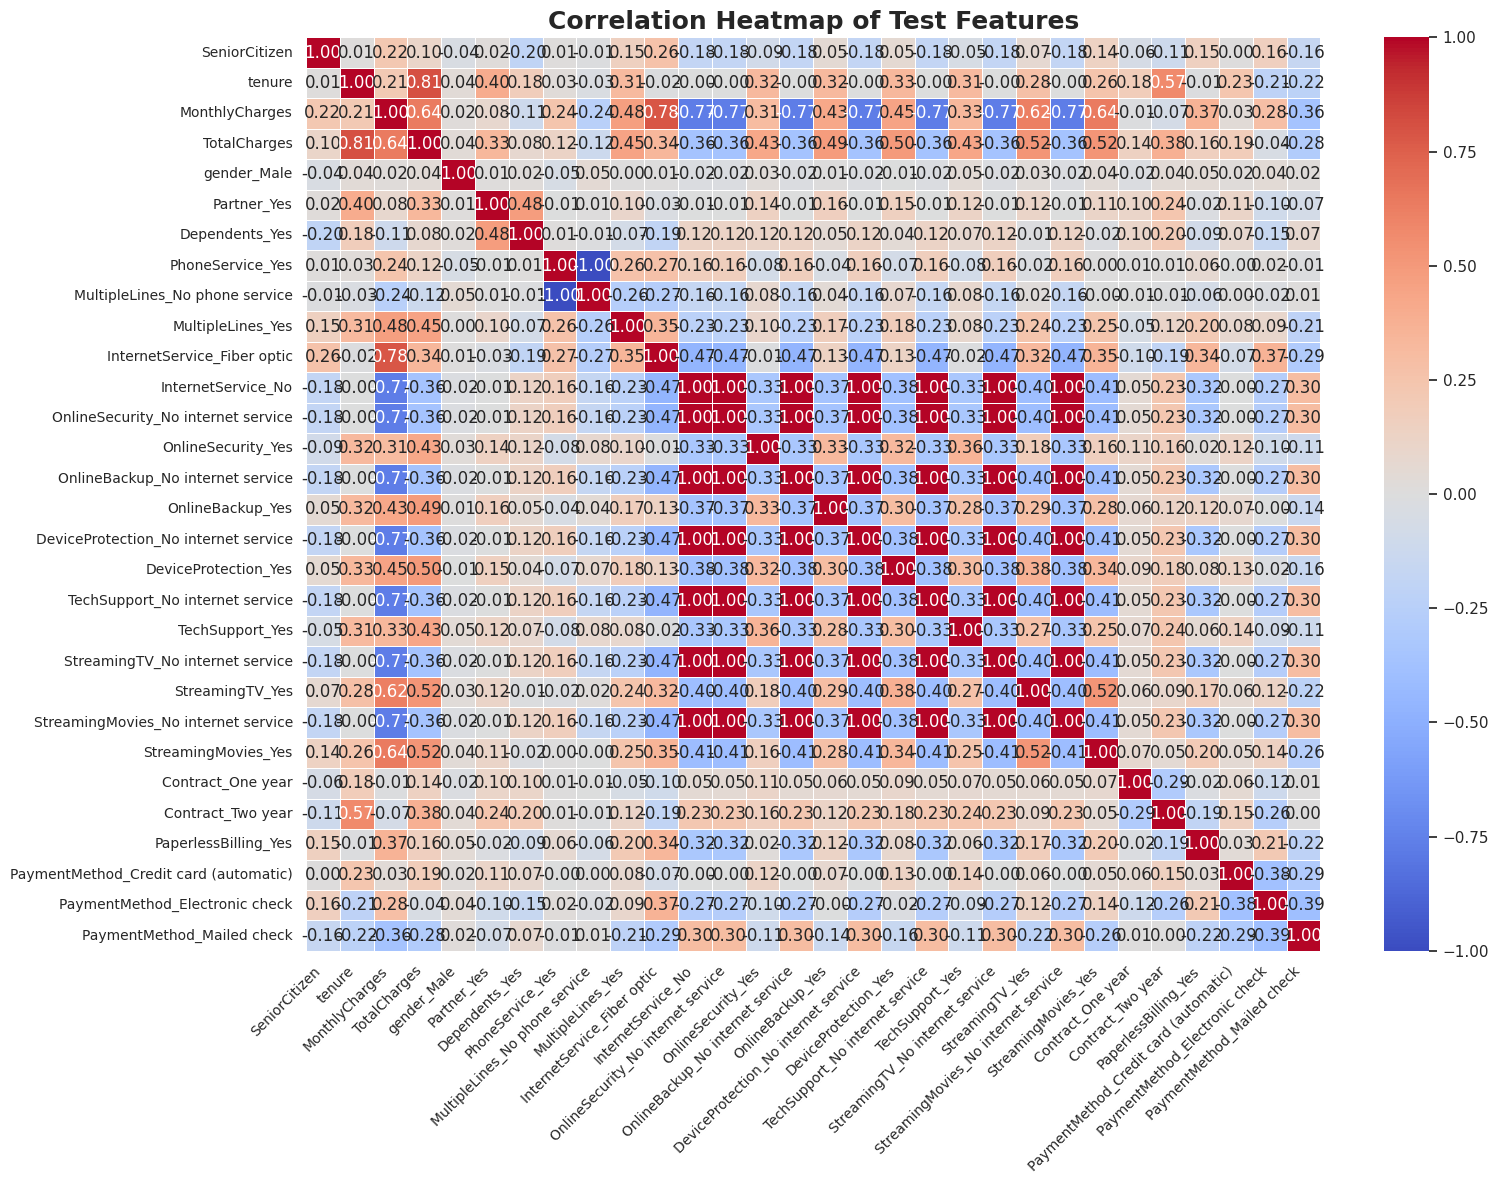

In [29]:
# Correlation Heatmap with Clear X-axis Labels
corr = X_test.corr()
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Test Features", fontsize=18, fontweight='bold')

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()